# Load audios

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import shutil
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

def unzip_files(zip_file_path, destination_folder):

  # destination_folder = zip_file_path.split('.zip')[0]

  # Create the destination folder if it doesn't exist
  if not os.path.exists(destination_folder):
      os.makedirs(destination_folder)

  # Open the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      # Get total number of files to extract
      total_files = len(zip_ref.namelist())

      # Extract all contents to the destination folder with progress bar
      for file in tqdm(zip_ref.namelist(), total=total_files, desc=f'Extracting {zip_file_path}', unit='files'):
          zip_ref.extract(file, destination_folder)

In [ ]:
unzip_files('/content/drive/MyDrive/Colab Notebooks/TFM/Exp2/OriginalAudios.zip', 'OriginalAudios')
unzip_files('/content/drive/MyDrive/Colab Notebooks/TFM/Exp2/ClonedAudiosout.zip', 'ClonedAudiosout')

Extracting /content/drive/MyDrive/Colab Notebooks/TFM/Exp2/OriginalAudios.zip: 100%|██████████| 7171/7171 [00:54<00:00, 131.72files/s]
Extracting /content/drive/MyDrive/Colab Notebooks/TFM/Exp2/ClonedAudiosout.zip: 100%|██████████| 13355/13355 [02:01<00:00, 109.75files/s]


In [ ]:
import wave
def get_audio_length(file_path):
    with wave.open(file_path, 'rb') as audio_file:
        # Get the number of frames and the frame rate
        num_frames = audio_file.getnframes()
        frame_rate = audio_file.getframerate()

        # Calculate the duration in seconds
        duration = num_frames / frame_rate

    return duration

# Load packages

In [ ]:
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt

!pip install resemblyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from resemblyzer import sampling_rate
from matplotlib import cm
from time import sleep, perf_counter as timer
from umap import UMAP
from sys import stderr
import matplotlib.pyplot as plt
import numpy as np

_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
    [89, 32, 12],
    [12, 200, 150],
    [250, 100, 50],
    [23, 34, 100],
], dtype=float) / 255


def play_wav(wav, blocking=True):
    try:
        import sounddevice as sd
        # Small bug with sounddevice.play: the audio is cut 0.5 second too early. We pad it to
        # make up for that
        wav = np.concatenate((wav, np.zeros(sampling_rate // 2)))
        sd.play(wav, sampling_rate, blocking=blocking)
    except Exception as e:
        print("Failed to play audio: %s" % repr(e))


def plot_similarity_matrix(matrix, labels_a=None, labels_b=None, ax: plt.Axes=None, title=""):
    if ax is None:
        _, ax = plt.subplots()
    fig = plt.gcf()

    img = ax.matshow(matrix, extent=(-0.5, matrix.shape[0] - 0.5,
                                     -0.5, matrix.shape[1] - 0.5))

    ax.xaxis.set_ticks_position("bottom")
    if labels_a is not None:
        ax.set_xticks(range(len(labels_a)))
        ax.set_xticklabels(labels_a, rotation=90)
    if labels_b is not None:
        ax.set_yticks(range(len(labels_b)))
        ax.set_yticklabels(labels_b[::-1])  # Upper origin -> reverse y axis
    ax.set_title(title)

    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15)
    fig.colorbar(img, cax=cax, ticks=np.linspace(0.4, 1, 7))
    img.set_clim(0.4, 1)
    img.set_cmap("inferno")

    return ax


def plot_histograms(all_samples, ax=None, names=None, title=""):
    """
    Plots (possibly) overlapping histograms and their median
    """
    if ax is None:
        _, ax = plt.subplots()

    for samples, color, name in zip(all_samples, _default_colors, names):
        ax.hist(samples + np.random.normal(0, 0.05, len(samples)), density=True, color=color + "80", label=name)
    ax.legend()
    ax.set_xlim(0.35, 1)
    ax.set_yticks([])
    ax.set_title(title)

    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)      # Yeah, I know
    for samples, color in zip(all_samples, _default_colors):
        median = np.median(samples)
        ax.vlines(median, *ylim, color, "dashed")
        ax.text(median, ylim[1] * 0.15, "median", rotation=270, color=color)

    return ax


# def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=True,
#                      title="", **kwargs):
#     if ax is None:
#         _, ax = plt.subplots(figsize=(6, 6))

#     # Compute the 2D projections. You could also project to another number of dimensions (e.g.
#     # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
#     reducer = UMAP(**kwargs)
#     projs = reducer.fit_transform(embeds)

#     # Draw the projections
#     speakers = np.array(speakers)
#     colors = colors or _my_colors
#     for i, speaker in enumerate(np.unique(speakers)):
#         speaker_projs = projs[speakers == speaker]
#         marker = "o" if markers is None else markers[i]
#         label = speaker if legend else None

#         ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)

#     if legend:
#         ax.legend(title="Speakers", ncol=2)
#     ax.set_title(title)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_aspect("equal")

#     return projs


def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=True,
                     title="", **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    # Compute the 2D projections. You could also project to another number of dimensions (e.g.
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs)
    projs = reducer.fit_transform(embeds)

    # Add noise to each point
    noise_level = 0.5
    projs = projs + np.random.normal(0, noise_level, size=projs.shape)

    # Draw the projections
    speakers = np.array(speakers)
    markers = np.array(markers)
    colors = colors or _my_colors

    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        # marker = "o" if markers is None else markers[i]
        marker = markers[speakers == speaker][0]
        label = speaker if legend else None

        # ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)
        plt.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label, alpha=0.7)

    if legend:
        ax.legend(title="Speakers", ncol=2)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

    return projs



def interactive_diarization(similarity_dict, wav, wav_splits, x_crop=5, show_time=False):
    fig, ax = plt.subplots()
    lines = [ax.plot([], [], label=name)[0] for name in similarity_dict.keys()]
    text = ax.text(0, 0, "", fontsize=10)

    def init():
        ax.set_ylim(0.4, 1)
        ax.set_ylabel("Similarity")
        if show_time:
            ax.set_xlabel("Time (seconds)")
        else:
            ax.set_xticks([])
        ax.set_title("Diarization")
        ax.legend(loc="lower right")
        return lines + [text]

    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    rate = 1 / (times[1] - times[0])
    crop_range = int(np.round(x_crop * rate))
    ticks = np.arange(0, len(wav_splits), rate)
    ref_time = timer()

    def update(i):
        # Crop plot
        crop = (max(i - crop_range // 2, 0), i + crop_range // 2)
        ax.set_xlim(i - crop_range // 2, crop[1])
        if show_time:
            crop_ticks = ticks[(crop[0] <= ticks) * (ticks <= crop[1])]
            ax.set_xticks(crop_ticks)
            ax.set_xticklabels(np.round(crop_ticks / rate).astype(np.int))

        # Plot the prediction
        similarities = [s[i] for s in similarity_dict.values()]
        best = np.argmax(similarities)
        name, similarity = list(similarity_dict.keys())[best], similarities[best]
        if similarity > 0.75:
            message = "Speaker: %s (confident)" % name
            color = _default_colors[best]
        elif similarity > 0.65:
            message = "Speaker: %s (uncertain)" % name
            color = _default_colors[best]
        else:
            message = "Unknown/No speaker"
            color = "black"
        text.set_text(message)
        text.set_c(color)
        text.set_position((i, 0.96))

        # Plot data
        for line, (name, similarities) in zip(lines, similarity_dict.items()):
            line.set_data(range(crop[0], i + 1), similarities[crop[0]:i + 1])

        # Block to synchronize with the audio (interval is not reliable)
        current_time = timer() - ref_time
        if current_time < times[i]:
            sleep(times[i] - current_time)
        elif current_time - 0.2 > times[i]:
            print("Animation is delayed further than 200ms!", file=stderr)
        return lines + [text]

    ani = FuncAnimation(fig, update, frames=len(wav_splits), init_func=init, blit=not show_time,
                        repeat=False, interval=1)
    play_wav(wav, blocking=False)
    plt.show()


def plot_embedding_as_heatmap(embed, ax=None, title="", shape=None, color_range=(0, 0.30)):
    if ax is None:
        _, ax = plt.subplots()

    if shape is None:
        height = int(np.sqrt(len(embed)))
        shape = (height, -1)
    embed = embed.reshape(shape)

    cmap = cm.get_cmap()
    mappable = ax.imshow(embed, cmap=cmap)
    cbar = plt.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_clim(*color_range)

    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title(title)

# Demo 1: Cross-similarity

## Prepare the data as necessary

In [ ]:
def prepare_audios(original_directory, new_directory, audios_per_speaker=100, min_duration=7):

  if os.path.isdir(new_directory):
    shutil.rmtree(new_directory)

  # Create the new directory if it doesn't exist
  os.makedirs(new_directory)

  wav_files = glob.glob(os.path.join(original_directory, '**/*.wav'), recursive=True)

  for wav_file in wav_files:

    filename = wav_file.split('/')[-1]
    speaker_id = wav_file.split('/')[1]

    duration = get_audio_length(wav_file)

    speaker_directory = os.path.join(new_directory, speaker_id)
    if not os.path.exists(speaker_directory):
      os.makedirs(speaker_directory)

    if (len(os.listdir(os.path.join(new_directory, speaker_id))) < audios_per_speaker) & (duration > min_duration):
      new_file_path = os.path.join(speaker_directory, filename)
      shutil.copy(wav_file, new_file_path)

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def demo1(audios_path):

  # DEMO 01: we'll show how to compare speech segments (=utterances) between them to get a metric
  # on how similar their voices sound. We expect utterances from the same speaker to have a high
  # similarity, and those from distinct speakers to have a lower one.


  # The neural network will automatically use CUDA if it'speaker available on your machine, otherwise it
  # will use the CPU. You can enforce a device of your choice by passing its name as argument to the
  # constructor. The model might take a few seconds to load with CUDA, but it then executes very
  # quickly.
  encoder = VoiceEncoder()

  # N.B. "wav" in variable names stands
  # for "waveform" and not the wav file extension.
  wav_fpaths = list(Path(audios_path).glob("**/*.wav"))
  wav_fpaths

  # Group the wavs per speaker and load them using the preprocessing function provided with
  # resemblyzer to load wavs in memory. It normalizes the volume, trims long silences and resamples
  # the wav to the correct sampling rate.
  speaker_wavs = {speaker: list(map(preprocess_wav, wav_fpaths)) for speaker, wav_fpaths in
                  groupby(tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs"),
                          lambda wav_fpath: wav_fpath.parent.stem)}

  ## Similarity between two utterances from each speaker
  # Embed two utterances A and B for each speaker
  embeds_a = np.array([encoder.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])
  embeds_b = np.array([encoder.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])
  # Each array is of shape (num_speakers, embed_size)
  print("Shape of embeddings: %s" % str(embeds_a.shape))

  # Compute the similarity matrix. The similarity of two embeddings is simply their dot
  # product, because the similarity metric is the cosine similarity and the embeddings are
  # already L2-normed.
  # Short version:
  # utt_sim_matrix = np.inner(embeds_a, embeds_b)
  # # Long, detailed version:
  # utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b)))
  # for i in range(len(embeds_a)):
  #     for j in range(len(embeds_b)):
  #         # The @ notation is exactly equivalent to np.dot(embeds_a[i], embeds_b[i])
  #         utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]
  # assert np.allclose(utt_sim_matrix, utt_sim_matrix2)


  ## Similarity between two speaker embeddings
  # Divide the utterances of each speaker in groups of identical size and embed each group as a
  # speaker embedding
  spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                          for wavs in speaker_wavs.values()])
  spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                          for wavs in speaker_wavs.values()])
  spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)


  ## Draw the plots
  fix, axs = plt.subplots(1, 2, figsize=(8, 4))
  labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
  labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
  mask = np.eye(len(spk_sim_matrix), dtype=bool)
  # plot_similarity_matrix(utt_sim_matrix, labels_a, labels_b, axs[0, 0],
  #                       "Cross-similarity between utterances\n(speaker_id-utterance_group)")
  # plot_histograms((utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
  #                 ["Same speaker", "Different speakers"],
  #                 "Normalized histogram of similarity\nvalues between utterances")
  plot_similarity_matrix(spk_sim_matrix, labels_a, labels_b, axs[0],)
                        # "Cross-similarity between speakers")
  plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]), axs[1],
                  ["Same speaker", "Different speakers"],)
                  # "Normalized histogram of similarity\nvalues between speakers")
  plt.show()





OriginalAudios_demo
Loaded the voice encoder model on cpu in 0.06 seconds.


Preprocessing wavs: 100%|██████████| 869/869 [01:02<00:00, 13.91wavs/s]


Shape of embeddings: (12, 256)


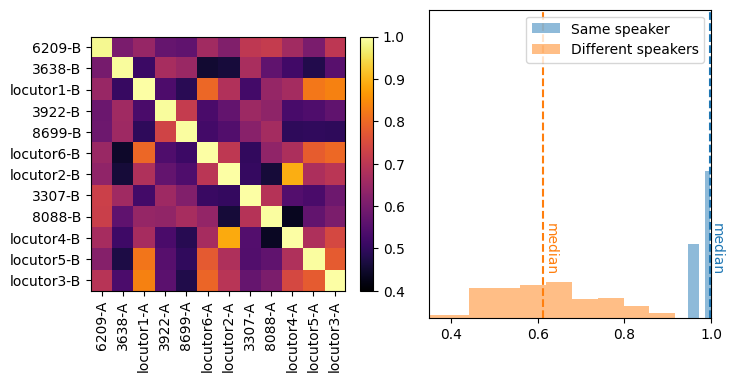





ClonedAudiosout_demo
Loaded the voice encoder model on cpu in 0.02 seconds.


Preprocessing wavs: 100%|██████████| 1200/1200 [00:38<00:00, 31.10wavs/s]


Shape of embeddings: (12, 256)


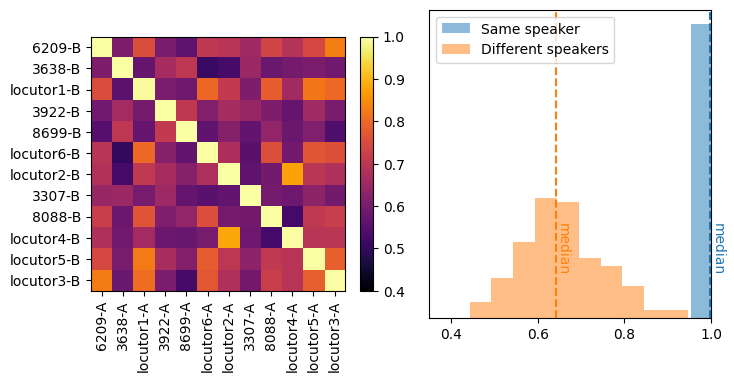

In [ ]:
original_directories = ['OriginalAudios', 'ClonedAudiosout']

for original_directory in original_directories:
    new_directory = original_directory + '_demo'
    prepare_audios(original_directory, new_directory, audios_per_speaker=100)
    print('\n\n\n')
    print(new_directory)
    demo1(new_directory)
    shutil.rmtree(new_directory)

# Demo 2: speaker diarization



In [ ]:
#

# Demo 3: speaker embeddings projection

In [ ]:
from sklearn.linear_model import LogisticRegression
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import numpy as np

def demo3(audios_path, sexes_dict):
  # DEMO 03: we'll show one way to visualize these utterance embeddings. Since they are
  # 256-dimensional, it is much simpler for us to get an overview of their manifold if we reduce
  # their dimensionality first. By doing so, we can observe clusters that form for utterances of
  # identical characteristics. What we'll see is that clusters form for distinct speakers,
  # and they are very tight and even linearly separable.


  ## Gather the wavs
  wav_fpaths = list(Path(audios_path).glob("**/*.wav"))
  speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
  wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths)))), dtype=object)
  speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in
                  groupby(range(len(wavs)), lambda i: speakers[i])}

  ## Compute the embeddings
  encoder = VoiceEncoder()
  utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))
  # Get the sex of each speaker
  markers = ["x" if sexes_dict[speaker] == "M" else "." for speaker in speakers]

  # ## Project the embeddings in 2D space
  _, ax = plt.subplots(figsize=(6, 6))

  projs = plot_projections(utterance_embeds, speakers, ax, markers=markers, legend=False)

  # ax.set_title("Embeddings for %d speakers" % (len(speakers)))
  ax.scatter([], [], marker="x", c="black", label="Male speaker")
  ax.scatter([], [], marker="o", c="black", label="Female speaker")

  # Separate the data by the sex
  classifier = LogisticRegression(solver="lbfgs")
  classifier.fit(projs, markers)
  x = np.linspace(*ax.get_xlim(), num=200)
  y = -(classifier.coef_[0, 0] * x + classifier.intercept_) / classifier.coef_[0, 1]
  mask = (y > ax.get_ylim()[0]) & (y < ax.get_ylim()[1])
  ax.plot(x[mask], y[mask], label="Decision boundary", linestyle='--')

  ax.legend()
  plt.show()





demo/ClonedAudiosout


Preprocessing wavs: 100%|██████████| 360/360 [00:12<00:00, 29.96it/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


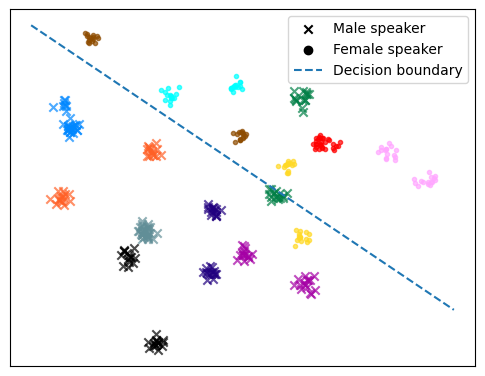

In [ ]:
# original_directories = ['OriginalAudios', 'ClonedAudiosout']
original_directories = ['ClonedAudiosout']

sexes_dict = {
              # Spanish
              'locutor1': 'M',
              'locutor2': 'F',
              'locutor3': 'M',
              'locutor4': 'F',
              'locutor5': 'M',
              'locutor6': 'M',
              # English
              '3922': 'F',
              '8699': 'F',
              '3638': 'F',
              '3307': 'M',
              '8088': 'M',
              '6209': 'M'
}


for original_directory in original_directories:
  new_directory = os.path.join('demo', original_directory)
  prepare_audios(original_directory, new_directory, audios_per_speaker=30)
  print('\n\n\n')
  print(new_directory)
  demo3(new_directory, sexes_dict)

shutil.rmtree('demo')

# Demo 5: fake speech detection

In [ ]:
# from resemblyzer import preprocess_wav, VoiceEncoder
# # from demo_utils import *
# from pathlib import Path
# from tqdm import tqdm
# import numpy as np

# def demo5(audios_path, fake_df, n_test=6):

#   # DEMO 05: In this demo we'll show how we can achieve a modest form of fake speech detection.
#   # This method assumes you have some reference audio for the target speaker that you
#   # know is real, so it is not a universal fake speech detector on its own.
#   # In each audio data directory we have segments. Some are real and extracted from
#   # actual speeches, while the remaining others are fake and generated by various models
#   # with a high discrepancy of voice cloning quality and naturalness achieved. We will
#   # take 6 segments of real speech as ground truth reference and compare those against the
#   # remaining. Those segments are selected at random, so will run into different results every time
#   # you run the script, but they should be more or less consistent.


#   ## Load and preprocess the audio
#   data_dir = Path(audios_path)
#   wav_fpaths = list(data_dir.glob("**/*.wav"))
#   wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
#           tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]


#   ## Compute the embeddings
#   encoder = VoiceEncoder()
#   embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
#   speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
#   names = np.array([fpath.stem for fpath in wav_fpaths])


#   # Take n_test real embeddings at random, and leave the others for testing
#   gt_indices = np.random.choice(*np.where(speakers == "real"), n_test, replace=False)
#   mask = np.zeros(len(embeds), dtype=bool)
#   mask[gt_indices] = True
#   gt_embeds = embeds[mask]
#   gt_names = names[mask]
#   gt_speakers = speakers[mask]
#   embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]


#   ## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
#   scores = (gt_embeds @ embeds.T).mean(axis=0)

#   # Order the scores by decreasing order
#   sort = np.argsort(scores)[::-1]
#   scores, names, speakers = scores[sort], names[sort], speakers[sort]

#   threshold = np.mean(scores)

#   ## Plot the scores
#   fig, _ = plt.subplots(figsize=(6, 6))
#   indices = np.arange(len(scores))
#   plt.axhline(threshold, ls="dashed", label="Prediction threshold", c="black")
#   plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
#   plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
#   plt.legend()
#   plt.xticks(indices, names, rotation="vertical", fontsize=8)
#   plt.xticks([])
#   # plt.xlabel("Audio IDs")
#   plt.ylim(min(scores) - 0.02, max(scores) + 0.02)
#   plt.ylabel("Similarity to ground truth")
#   fig.subplots_adjust(bottom=0.25)
#   plt.show()

#   # print(scores, names, speakers, indices)

#   predictions = ["real" if score > threshold else "fake" for score in scores]

#   new_rows = pd.DataFrame({'Speaker ID': speaker_id,
#                            'Audio ID': names,
#                            'True label': speakers,
#                            'Predicted label': predictions})

#   fake_df = pd.concat([fake_df, new_rows], ignore_index=True)

#   return fake_df

In [ ]:
import random

def prepare_data_demo5(speaker_id, min_dur=3, max_audios=40):

  if os.path.exists(f'demo_{speaker_id}'):
    shutil.rmtree(f'demo_{speaker_id}')

  os.makedirs(f'demo_{speaker_id}/real')
  os.makedirs(f'demo_{speaker_id}/fake')

  real_audios = glob.glob(os.path.join('OriginalAudios', speaker_id, '**/*.wav'), recursive=True)
  random.shuffle(real_audios)

  for audio in real_audios:
    if (len(os.listdir(f'demo_{speaker_id}/real')) < max_audios / 2) & (get_audio_length(audio) > min_dur):
      shutil.copy(audio, os.path.join(f'demo_{speaker_id}/real', audio.split('/')[-1]))

  fake_audios = glob.glob(os.path.join('ClonedAudiosout', speaker_id, '**/*.wav'), recursive=True)
  random.shuffle(fake_audios)

  for audio in fake_audios:
    if (len(os.listdir(f'demo_{speaker_id}/fake')) < max_audios / 2) & (get_audio_length(audio) > min_dur):
      shutil.copy(audio, os.path.join(f'demo_{speaker_id}/fake', audio.split('/')[-1]))

In [ ]:
# speaker_ids = [speaker_id for speaker_id in os.listdir('ClonedAudiosout') if 'csv' not in speaker_id]
# for speaker_id in speaker_ids:
#   prepare_data_demo5(speaker_id, min_dur=2, max_audios=9999)
#   print('\nspeaker: '+speaker_id)
#   print('real audios: ' + str(len(os.listdir(f'demo_{speaker_id}/real'))), ', fake_audios: ' + str(len(os.listdir(f'demo_{speaker_id}/fake'))))
#   print('total: ' + str(len(os.listdir(f'demo_{speaker_id}/real'))+len(os.listdir(f'demo_{speaker_id}/fake'))))
#   shutil.rmtree(f'demo_{speaker_id}')

In [ ]:
# fake_df = pd.DataFrame(columns=['Speaker ID', 'Audio ID', 'True label', 'Predicted label'])

# speaker_ids = [speaker_id for speaker_id in os.listdir('ClonedAudiosout') if 'csv' not in speaker_id ]

# for speaker_id in speaker_ids:
#   print('\n'+speaker_id)
#   prepare_data_demo5(speaker_id, min_dur=2, max_audios=9999)
#   fake_df = demo5('demo_'+speaker_id, fake_df, n_test=50)
#   shutil.rmtree('demo_'+speaker_id)

#   # Poner min_dur=0 y max_audios = 9999 (un número muy alto para coger todos los audios) (tarda 6 mins por locutor).
#   # Poner n_test un numero altito (50)

In [ ]:
# def get_source_language(audio_id):

#   return 'Spanish' if 'audio' in audio_id else 'English'

# languages_dict = {
#               # Spanish
#               'locutor1': 'Spanish',
#               'locutor2': 'Spanish',
#               'locutor3': 'Spanish',
#               'locutor4': 'Spanish',
#               'locutor5': 'Spanish',
#               'locutor6': 'Spanish',
#               # English
#               '3922': 'English',
#               '8699': 'English',
#               '3638': 'English',
#               '3307': 'English',
#               '8088': 'English',
#               '6209': 'English'
# }

# fake_df['Source speaker language'] = fake_df['Audio ID'].apply(get_source_language)
# fake_df.loc[fake_df['True label'] == 'real', 'Source speaker language'] = np.nan
# fake_df['Speaker language'] = fake_df['Speaker ID'].map(languages_dict)

In [ ]:
# fake_df['y_true'] = fake_df['True label'].apply(lambda x: 0 if x == 'real' else 1)
# fake_df['y_pred'] = fake_df['Predicted label'].apply(lambda x: 0 if x == 'real' else 1)
# fake_df

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score

# fig, ax = plt.subplots()

# cm = confusion_matrix(fake_df['y_true'], fake_df['y_pred'])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(ax=ax, colorbar=False, text_kw = {'fontsize': 25})
# ax.set_title('Predicted label', fontsize=17)
# ax.set_xticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)
# ax.set_ylabel('True label', fontsize=17)
# ax.set_xlabel('')
# ax.set_yticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)

# accuracy = accuracy_score(fake_df['y_true'], fake_df['y_pred'])
# precision = precision_score(fake_df['y_true'], fake_df['y_pred'])
# sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
# specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# metrics_df = pd.DataFrame({'Model': ['SO-VITS-SVC'],
#                         'Accuracy': [accuracy],
#                         'Precision': [precision],
#                         'Sensitivity': [sensitivity],
#                         'Specificity': [specificity]
#                         })
# plt.show()

In [ ]:
# metrics_df

In [ ]:
# fake_df = pd.DataFrame(columns=['Speaker ID', 'Audio ID', 'True label', 'Predicted label'])

# speaker_ids = [speaker_id for speaker_id in os.listdir('ClonedAudiosout') if 'csv' not in speaker_id ]

# for speaker_id in speaker_ids:
#   print('\n'+speaker_id)
#   prepare_data_demo5(speaker_id, min_dur=2, max_audios=9999)
#   fake_df = demo5('demo_'+speaker_id, fake_df, n_test=6)
#   shutil.rmtree('demo_'+speaker_id)

#   # Poner min_dur=0 y max_audios = 9999 (un número muy alto para coger todos los audios) (tarda 6 mins por locutor).
#   # Poner n_test un numero altito (50)

In [ ]:
# def get_source_language(audio_id):

#   return 'Spanish' if 'audio' in audio_id else 'English'

# languages_dict = {
#               # Spanish
#               'locutor1': 'Spanish',
#               'locutor2': 'Spanish',
#               'locutor3': 'Spanish',
#               'locutor4': 'Spanish',
#               'locutor5': 'Spanish',
#               'locutor6': 'Spanish',
#               # English
#               '3922': 'English',
#               '8699': 'English',
#               '3638': 'English',
#               '3307': 'English',
#               '8088': 'English',
#               '6209': 'English'
# }

# fake_df['Source speaker language'] = fake_df['Audio ID'].apply(get_source_language)
# fake_df.loc[fake_df['True label'] == 'real', 'Source speaker language'] = np.nan
# fake_df['Speaker language'] = fake_df['Speaker ID'].map(languages_dict)

In [ ]:
# fake_df['y_true'] = fake_df['True label'].apply(lambda x: 0 if x == 'real' else 1)
# fake_df['y_pred'] = fake_df['Predicted label'].apply(lambda x: 0 if x == 'real' else 1)
# fake_df

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score

# fig, ax = plt.subplots()

# cm = confusion_matrix(fake_df['y_true'], fake_df['y_pred'])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(ax=ax, colorbar=False, text_kw = {'fontsize': 25})
# ax.set_title('Predicted label', fontsize=17)
# ax.set_xticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)
# ax.set_ylabel('True label', fontsize=17)
# ax.set_xlabel('')
# ax.set_yticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)

# accuracy = accuracy_score(fake_df['y_true'], fake_df['y_pred'])
# precision = precision_score(fake_df['y_true'], fake_df['y_pred'])
# sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
# specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# metrics_df = pd.DataFrame({'Model': ['SO-VITS-SVC'],
#                         'Accuracy': [accuracy],
#                         'Precision': [precision],
#                         'Sensitivity': [sensitivity],
#                         'Specificity': [specificity]
#                         })
# plt.show()

In [ ]:
# metrics_df

In [ ]:
###########

In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
# from demo_utils import *
from pathlib import Path
from tqdm import tqdm
import numpy as np

def demo5(audios_path, speaker_id, fake_df, n_test=6):

  # DEMO 05: In this demo we'll show how we can achieve a modest form of fake speech detection.
  # This method assumes you have some reference audio for the target speaker that you
  # know is real, so it is not a universal fake speech detector on its own.
  # In each audio data directory we have segments. Some are real and extracted from
  # actual speeches, while the remaining others are fake and generated by various models
  # with a high discrepancy of voice cloning quality and naturalness achieved. We will
  # take 6 segments of real speech as ground truth reference and compare those against the
  # remaining. Those segments are selected at random, so will run into different results every time
  # you run the script, but they should be more or less consistent.


  ## Load and preprocess the audio
  data_dir = Path(audios_path)
  wav_fpaths = list(data_dir.glob("**/*.wav"))
  wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
          tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]


  ## Compute the embeddings
  encoder = VoiceEncoder()
  embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
  speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
  names = np.array([fpath.stem for fpath in wav_fpaths])


  # Take n_test real embeddings at random, and leave the others for testing
  gt_indices = np.random.choice(*np.where(speakers == "real"), n_test, replace=False)
  mask = np.zeros(len(embeds), dtype=bool)
  mask[gt_indices] = True
  gt_embeds = embeds[mask]
  gt_names = names[mask]
  gt_speakers = speakers[mask]
  embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]


  ## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
  scores = (gt_embeds @ embeds.T).mean(axis=0)

  # Order the scores by decreasing order
  sort = np.argsort(scores)[::-1]
  scores, names, speakers = scores[sort], names[sort], speakers[sort]

  threshold = np.mean(scores)

  ## Plot the scores
  # fig, _ = plt.subplots(figsize=(6, 6))
  # indices = np.arange(len(scores))
  # plt.axhline(threshold, ls="dashed", label="Prediction threshold", c="black")
  # plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
  # plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
  # plt.legend()
  # plt.xticks(indices, names, rotation="vertical", fontsize=8)
  # plt.xticks([])
  # # plt.xlabel("Audio IDs")
  # plt.ylim(min(scores) - 0.02, max(scores) + 0.02)
  # plt.ylabel("Similarity to ground truth")
  # fig.subplots_adjust(bottom=0.25)
  # plt.show()

  # print(scores, names, speakers, indices)

  predictions = ["real" if score > threshold else "fake" for score in scores]

  new_rows = pd.DataFrame({'n_test': n_test,
                           'Speaker ID': speaker_id,
                           'Audio ID': names,
                           'True label': speakers,
                           'Predicted label': predictions})

  fake_df = pd.concat([fake_df, new_rows], ignore_index=True)

  return fake_df

In [ ]:
def get_fake_df(fake_df, n_test):

  speaker_ids = [speaker_id for speaker_id in os.listdir('ClonedAudiosout') if 'csv' not in speaker_id ]

  for speaker_id in speaker_ids:
    print('\n'+speaker_id)
    prepare_data_demo5(speaker_id, min_dur=2, max_audios=9999)
    fake_df = demo5('demo_'+speaker_id, speaker_id, fake_df, n_test=n_test)
    shutil.rmtree('demo_'+speaker_id)

  return fake_df
  # Poner min_dur=0 y max_audios = 9999 (un número muy alto para coger todos los audios) (tarda 6 mins por locutor).
  # Poner n_test un numero altito (50)

In [ ]:
def get_source_language(audio_id):

  return 'Spanish' if 'audio' in audio_id else 'English'

def complete_fake_df(fake_df):

  languages_dict = {
                # Spanish
                'locutor1': 'Spanish',
                'locutor2': 'Spanish',
                'locutor3': 'Spanish',
                'locutor4': 'Spanish',
                'locutor5': 'Spanish',
                'locutor6': 'Spanish',
                # English
                '3922': 'English',
                '8699': 'English',
                '3638': 'English',
                '3307': 'English',
                '8088': 'English',
                '6209': 'English'
  }

  fake_df['Source speaker language'] = fake_df['Audio ID'].apply(get_source_language)
  fake_df.loc[fake_df['True label'] == 'real', 'Source speaker language'] = np.nan
  fake_df['Speaker language'] = fake_df['Speaker ID'].map(languages_dict)
  fake_df['y_true'] = fake_df['True label'].apply(lambda x: 0 if x == 'real' else 1)
  fake_df['y_pred'] = fake_df['Predicted label'].apply(lambda x: 0 if x == 'real' else 1)

  return fake_df

In [ ]:
def plot_cm(fake_df, metrics_df, n_test):
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import precision_score

  fig, ax = plt.subplots()

  fake_df_n_test = fake_df[fake_df['n_test'] == n_test]

  cm = confusion_matrix(fake_df_n_test['y_true'], fake_df_n_test['y_pred'])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(ax=ax, colorbar=False, text_kw = {'fontsize': 25})
  ax.set_title('Predicted label', fontsize=17)
  ax.set_xticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)
  ax.set_ylabel('True label', fontsize=17)
  ax.set_xlabel('')
  ax.set_yticks(ticks=[0, 1], labels=['Real', 'Fake'], fontsize=14)

  accuracy = accuracy_score(fake_df_n_test['y_true'], fake_df_n_test['y_pred'])
  precision = precision_score(fake_df_n_test['y_true'], fake_df_n_test['y_pred'])
  sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
  specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

  new_row = pd.DataFrame({'n_test': [n_test],
                          'Accuracy': [accuracy],
                          'Precision': [precision],
                          'Sensitivity': [sensitivity],
                          'Specificity': [specificity]
                          })
  plt.show()

  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

  return metrics_df


6209


Preprocessing wavs: 100%|██████████| 1241/1241 [00:27<00:00, 45.38 utterances/s]


Loaded the voice encoder model on cpu in 0.03 seconds.

3638


Preprocessing wavs: 100%|██████████| 1229/1229 [00:26<00:00, 46.05 utterances/s]


Loaded the voice encoder model on cpu in 0.03 seconds.

locutor1


Preprocessing wavs: 100%|██████████| 1739/1739 [00:43<00:00, 40.30 utterances/s]


Loaded the voice encoder model on cpu in 0.03 seconds.

3922


Preprocessing wavs: 100%|██████████| 1280/1280 [00:28<00:00, 45.39 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8699


Preprocessing wavs: 100%|██████████| 1281/1281 [00:28<00:00, 44.59 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor6


Preprocessing wavs: 100%|██████████| 1727/1727 [00:43<00:00, 39.63 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor2


Preprocessing wavs: 100%|██████████| 1734/1734 [00:41<00:00, 41.72 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3307


Preprocessing wavs: 100%|██████████| 1180/1180 [00:28<00:00, 41.62 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8088


Preprocessing wavs: 100%|██████████| 1221/1221 [00:27<00:00, 44.19 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor4


Preprocessing wavs: 100%|██████████| 1720/1720 [00:43<00:00, 39.49 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor5


Preprocessing wavs: 100%|██████████| 1740/1740 [00:43<00:00, 39.94 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor3


Preprocessing wavs: 100%|██████████| 1753/1753 [00:44<00:00, 39.82 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.


 n_test = 1


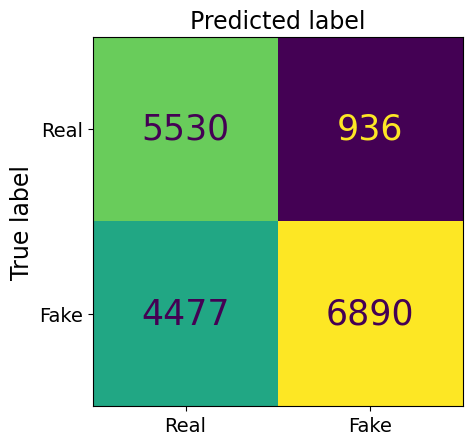


6209


Preprocessing wavs: 100%|██████████| 1241/1241 [00:27<00:00, 45.04 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3638


Preprocessing wavs: 100%|██████████| 1229/1229 [00:29<00:00, 41.62 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor1


Preprocessing wavs: 100%|██████████| 1739/1739 [00:44<00:00, 39.51 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3922


Preprocessing wavs: 100%|██████████| 1280/1280 [00:34<00:00, 37.07 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8699


Preprocessing wavs: 100%|██████████| 1281/1281 [00:29<00:00, 43.51 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor6


Preprocessing wavs: 100%|██████████| 1727/1727 [00:45<00:00, 38.06 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor2


Preprocessing wavs: 100%|██████████| 1734/1734 [00:43<00:00, 40.05 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

3307


Preprocessing wavs: 100%|██████████| 1180/1180 [00:28<00:00, 41.56 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8088


Preprocessing wavs: 100%|██████████| 1221/1221 [00:29<00:00, 42.10 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor4


Preprocessing wavs: 100%|██████████| 1720/1720 [00:43<00:00, 39.95 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor5


Preprocessing wavs: 100%|██████████| 1740/1740 [00:43<00:00, 40.05 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor3


Preprocessing wavs: 100%|██████████| 1753/1753 [00:44<00:00, 39.69 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.


 n_test = 6


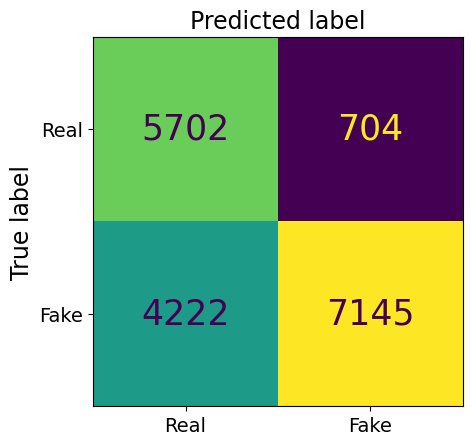


6209


Preprocessing wavs: 100%|██████████| 1241/1241 [00:27<00:00, 44.41 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

3638


Preprocessing wavs: 100%|██████████| 1229/1229 [00:27<00:00, 44.44 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor1


Preprocessing wavs: 100%|██████████| 1739/1739 [00:44<00:00, 38.86 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3922


Preprocessing wavs: 100%|██████████| 1280/1280 [00:28<00:00, 45.36 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8699


Preprocessing wavs: 100%|██████████| 1281/1281 [00:29<00:00, 44.10 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor6


Preprocessing wavs: 100%|██████████| 1727/1727 [00:44<00:00, 39.08 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor2


Preprocessing wavs: 100%|██████████| 1734/1734 [00:45<00:00, 37.87 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3307


Preprocessing wavs: 100%|██████████| 1180/1180 [00:28<00:00, 40.96 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8088


Preprocessing wavs: 100%|██████████| 1221/1221 [00:27<00:00, 43.80 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor4


Preprocessing wavs: 100%|██████████| 1720/1720 [00:43<00:00, 40.00 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor5


Preprocessing wavs: 100%|██████████| 1740/1740 [00:44<00:00, 39.23 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor3


Preprocessing wavs: 100%|██████████| 1753/1753 [00:44<00:00, 39.51 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


 n_test = 30


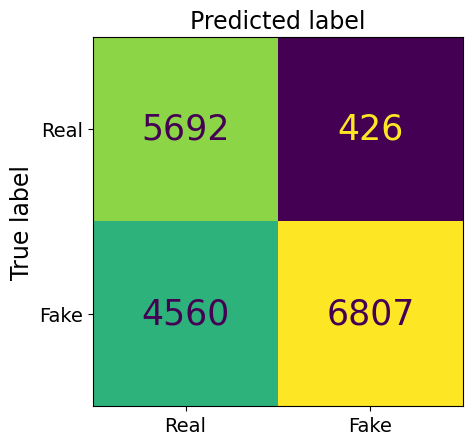


6209


Preprocessing wavs: 100%|██████████| 1241/1241 [00:28<00:00, 42.91 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3638


Preprocessing wavs: 100%|██████████| 1229/1229 [00:30<00:00, 39.91 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor1


Preprocessing wavs: 100%|██████████| 1739/1739 [00:46<00:00, 37.71 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3922


Preprocessing wavs: 100%|██████████| 1280/1280 [00:29<00:00, 43.95 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8699


Preprocessing wavs: 100%|██████████| 1281/1281 [00:29<00:00, 43.63 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor6


Preprocessing wavs: 100%|██████████| 1727/1727 [00:45<00:00, 37.83 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor2


Preprocessing wavs: 100%|██████████| 1734/1734 [00:43<00:00, 39.59 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

3307


Preprocessing wavs: 100%|██████████| 1180/1180 [00:28<00:00, 40.79 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8088


Preprocessing wavs: 100%|██████████| 1221/1221 [00:28<00:00, 42.27 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor4


Preprocessing wavs: 100%|██████████| 1720/1720 [00:47<00:00, 36.07 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor5


Preprocessing wavs: 100%|██████████| 1740/1740 [00:44<00:00, 39.25 utterances/s]


Loaded the voice encoder model on cpu in 0.03 seconds.

locutor3


Preprocessing wavs: 100%|██████████| 1753/1753 [00:47<00:00, 37.14 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.


 n_test = 50


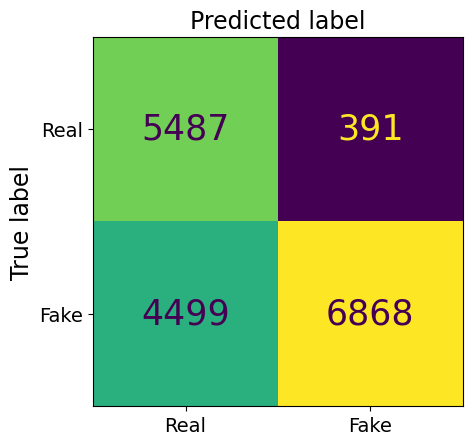


6209


Preprocessing wavs: 100%|██████████| 1241/1241 [00:28<00:00, 43.53 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

3638


Preprocessing wavs: 100%|██████████| 1229/1229 [00:30<00:00, 40.72 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor1


Preprocessing wavs: 100%|██████████| 1739/1739 [00:42<00:00, 40.72 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

3922


Preprocessing wavs: 100%|██████████| 1280/1280 [00:28<00:00, 45.05 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

8699


Preprocessing wavs: 100%|██████████| 1281/1281 [00:27<00:00, 45.89 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

locutor6


Preprocessing wavs: 100%|██████████| 1727/1727 [00:44<00:00, 38.80 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor2


Preprocessing wavs: 100%|██████████| 1734/1734 [00:38<00:00, 45.40 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

3307


Preprocessing wavs: 100%|██████████| 1180/1180 [00:25<00:00, 46.37 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.

8088


Preprocessing wavs: 100%|██████████| 1221/1221 [00:27<00:00, 43.91 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor4


Preprocessing wavs: 100%|██████████| 1720/1720 [00:41<00:00, 41.65 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor5


Preprocessing wavs: 100%|██████████| 1740/1740 [00:41<00:00, 42.38 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.

locutor3


Preprocessing wavs: 100%|██████████| 1753/1753 [00:41<00:00, 42.72 utterances/s]


Loaded the voice encoder model on cpu in 0.02 seconds.


 n_test = 100


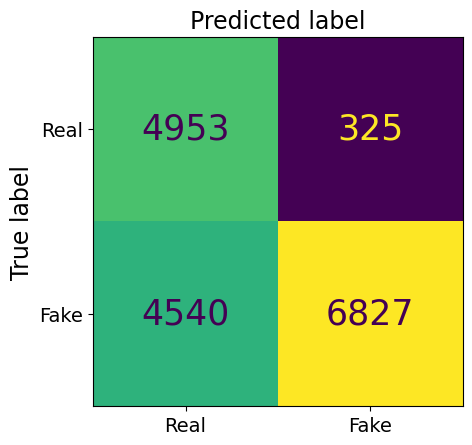

In [ ]:
n_test_list = [1, 6, 30, 50, 100]

fake_df = pd.DataFrame()
metrics_df = pd.DataFrame()

for n_test in n_test_list:
  fake_df = get_fake_df(fake_df, n_test)
  fake_df = complete_fake_df(fake_df)
  print('\n\n n_test = '+ str(n_test))
  metrics_df = plot_cm(fake_df, metrics_df, n_test)

In [ ]:
fake_df

,n_test,Speaker ID,Audio ID,True label,Predicted label,Source speaker language,Speaker language,y_true,y_pred
0,1,6209,6209_34599_000007_000003,real,real,NaN,English,0,0
1,1,6209,8088_284756_000000_000000.out,fake,real,English,English,1,0
2,1,6209,6209_34599_000005_000002,real,real,NaN,English,0,0
3,1,6209,8088_284756_000125_000004.out,fake,real,English,English,1,0
4,1,6209,6209_34599_000007_000004,real,real,NaN,English,0,0
...,...,...,...,...,...,...,...,...,...
86976,100,locutor3,8699_291107_000098_000000.out,fake,fake,English,Spanish,1,1
86977,100,locutor3,6209_34601_000068_000016.out,fake,fake,English,Spanish,1,1
86978,100,locutor3,3307_145138_000014_000001.out,fake,fake,English,Spanish,1,1
86979,100,locutor3,3307_145145_000038_000006.out,fake,fake,English,Spanish,1,1


In [ ]:
metrics_df

,n_test,Accuracy,Precision,Sensitivity,Specificity
0,1,0.696462,0.880399,0.606141,0.855243
1,6,0.722838,0.910307,0.628574,0.890103
2,30,0.714841,0.941103,0.598839,0.930369
3,50,0.716440,0.946136,0.604205,0.933481
4,100,0.707720,0.954558,0.600598,0.938424


In [ ]:
fake_df.to_csv('fake_df.csv', index=False)
metrics_df.to_csv('metrics_df.csv', index=False)

In [ ]:
from google.colab import files
files.download("fake_df.csv")
files.download("metrics_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

fake_df = pd.read_csv('fake_df.csv')
metrics_df = pd.read_csv('metrics_df.csv')

In [ ]:
# P(cross language voice transfer | fn) Probabilidad de que se haya transferido la voz entre distintos idiomas dado un falso negativo
# falso negativo es considerar que un audio es real cuando es fake
p_clvt_fn_dict = {}

for n_test in fake_df['n_test'].unique():
  fake_df_n_test = fake_df[fake_df['n_test'] == n_test]

  fake_df_fn = fake_df_n_test[(fake_df_n_test['True label'] == 'fake') & (fake_df_n_test['Predicted label'] == 'real')]
  fn = len(fake_df_fn)

  fake_df_clvt_fn = fake_df_fn[fake_df_fn['Source speaker language'] != fake_df_fn['Speaker language']]
  clvt_fn = len(fake_df_clvt_fn)

  print('\nn_test: ' + str(n_test))
  print('fn: ' + str(fn))
  print('clvt_fn: ' + str(clvt_fn))

  p_clvt_fn_dict[str(n_test)] = clvt_fn / fn



n_test: 1
fn: 4477
clvt_fn: 473

n_test: 6
fn: 4222
clvt_fn: 435

n_test: 30
fn: 4560
clvt_fn: 177

n_test: 50
fn: 4499
clvt_fn: 172

n_test: 100
fn: 4540
clvt_fn: 219


In [ ]:
p_clvt_fn_dict

{'1': 0.10565110565110565,
 '6': 0.10303173851255329,
 '30': 0.03881578947368421,
 '50': 0.03823071793731941,
 '100': 0.048237885462555065}

In [ ]:
# Contar los audios que hay de cada caso para ver que están equilibrados (sp->sp, en->en, sp->en, en->sp)

In [ ]:
fake_df_out = fake_df[fake_df['True label'] == 'fake'].copy()
fake_df_out['cross language voice transfer'] = [True if fake_df_out.loc[index, 'Source speaker language'] != fake_df_out.loc[index, 'Speaker language'] else False for index, _ in fake_df_out.iterrows()]
fake_df_out['Languages'] = fake_df_out['Speaker language'] + '->' + fake_df_out['Source speaker language']
fake_df_out

,n_test,Speaker ID,Audio ID,True label,Predicted label,Source speaker language,Speaker language,y_true,y_pred,cross language voice transfer,Languages
1,1,6209,8088_284756_000000_000000.out,fake,real,English,English,1,0,False,English->English
3,1,6209,8088_284756_000125_000004.out,fake,real,English,English,1,0,False,English->English
7,1,6209,8088_284756_000078_000001.out,fake,real,English,English,1,0,False,English->English
8,1,6209,3922_715_000008_000001.out,fake,real,English,English,1,0,False,English->English
9,1,6209,8088_284756_000057_000000.out,fake,real,English,English,1,0,False,English->English
...,...,...,...,...,...,...,...,...,...,...,...
86976,100,locutor3,8699_291107_000098_000000.out,fake,fake,English,Spanish,1,1,True,Spanish->English
86977,100,locutor3,6209_34601_000068_000016.out,fake,fake,English,Spanish,1,1,True,Spanish->English
86978,100,locutor3,3307_145138_000014_000001.out,fake,fake,English,Spanish,1,1,True,Spanish->English
86979,100,locutor3,3307_145145_000038_000006.out,fake,fake,English,Spanish,1,1,True,Spanish->English


In [ ]:
fake_df_out['cross language voice transfer'].sum() / len(fake_df_out)

0.5447347585114806

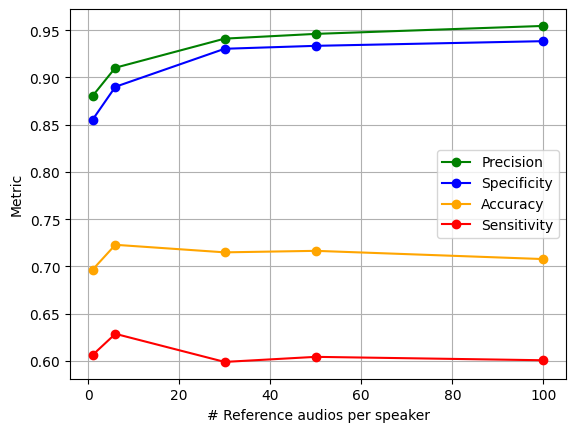

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure()
plt.plot(metrics_df['n_test'], metrics_df['Precision'], marker='o', color='green', label='Precision')
plt.plot(metrics_df['n_test'], metrics_df['Specificity'], marker='o', color='blue', label='Specificity')
plt.plot(metrics_df['n_test'], metrics_df['Accuracy'], marker='o', color='orange', label='Accuracy')
plt.plot(metrics_df['n_test'], metrics_df['Sensitivity'], marker='o', color='red', label='Sensitivity')

# Adding labels and title
plt.xlabel('# Reference audios per speaker')
plt.ylabel('Metric')
plt.title('')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# ROC

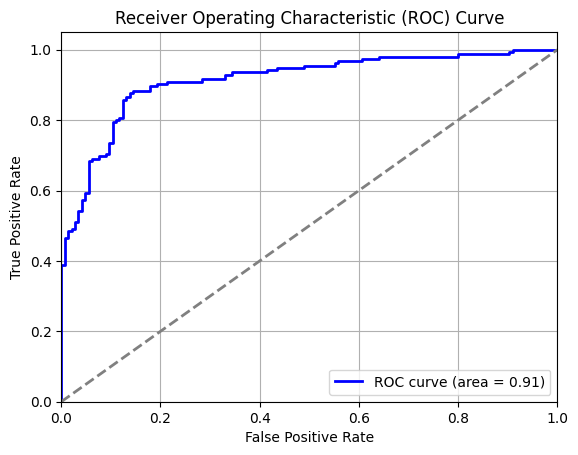

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
metadata_df = pd.read_csv('metadata_with_wer.csv').sample(1000, random_state=0)

In [ ]:
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path

encoder = VoiceEncoder()

def extract_audio_embeds(audio_path):

  fpath = Path(audio_path)
  wav = preprocess_wav(fpath)
  embed = encoder.embed_utterance(wav)

  return embed

Loaded the voice encoder model on cpu in 0.05 seconds.


In [ ]:
from tqdm import tqdm

tqdm.pandas()

metadata_df['Embedding'] = metadata_df['Audio path'].progress_apply(extract_audio_embeds)
metadata_df

100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


,Model,Reference audio path,Source audio path,Audio path,Source speaker ID,Speaker ID,Duration audio,RTF GPU,RTF CPU,SECS,...,Evaluator 4 Sim-OS,Evaluator 5 OS,Evaluator 5 Sim-OS,Evaluator 6 OS,Evaluator 6 Sim-OS,Evaluator 7 OS,Evaluator 7 Sim-OS,Evaluator 8 OS,Evaluator 8 Sim-OS,Embedding
8241,so-vits-svc,OriginalAudios/locutor6/audio_2943.wav,OriginalAudios/locutor2/audio_7499_7500.wav,ClonedAudiosout/locutor6/locutor2/audio_7499_7...,locutor2,locutor6,7.337506,0.869821,1.490857,0.856260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0033592049, 0.0, 0.21405777, 0.0, 0.0279819..."
7685,so-vits-svc,OriginalAudios/8088/8088_284756_000083_000002.wav,OriginalAudios/6209/6209_34600_000028_000003.wav,ClonedAudiosout/8088/6209/6209_34600_000028_00...,6209,8088,6.010045,1.080935,1.805810,0.835790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.23467758, 0.0, 0.0, 0.0, 0.057833..."
6244,so-vits-svc,OriginalAudios/locutor2/audio_208_209_210.wav,OriginalAudios/3307/3307_145145_000038_000002.wav,ClonedAudiosout/locutor2/3307/3307_145145_0000...,3307,locutor2,8.920045,0.731929,1.058909,0.864729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.39977863, 0.0, 0.0, 0.0050265864,..."
2383,so-vits-svc,OriginalAudios/locutor5/audio_11555_11556_1155...,OriginalAudios/locutor4/audio_21530.wav,ClonedAudiosout/locutor5/locutor4/audio_21530....,locutor4,locutor5,9.137052,0.696242,1.226796,0.947807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.057090487, 0.0, 0.13396041, 0.0, 0.0, 0.002..."
17401,Ground truth,OriginalAudios/locutor3/audio_1054.wav,NaN,OriginalAudios/locutor3/audio_3312.wav,NaN,locutor3,6.400000,NaN,NaN,0.784118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.008110408, 0.0339425, 0.12782435, 0.0, 0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15417,Ground truth,OriginalAudios/locutor6/audio_4047_4048_4049.wav,NaN,OriginalAudios/locutor6/audio_41258.wav,NaN,locutor6,5.000000,NaN,NaN,0.864577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.073637165, 0.0, 0.2798926, 0.0, 0.033121012..."
3268,so-vits-svc,OriginalAudios/locutor5/audio_7498.wav,OriginalAudios/6209/6209_34601_000162_000001.wav,ClonedAudiosout/locutor5/6209/6209_34601_00016...,6209,locutor5,3.790045,1.682160,2.204572,0.783594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.09985611, 0.0, 0.27634665, 0.0, 0.0, 0.0, 0..."
18631,Ground truth,OriginalAudios/locutor5/audio_1676_1677.wav,NaN,OriginalAudios/locutor5/audio_3916_3917.wav,NaN,locutor5,5.770159,NaN,NaN,0.910188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,"[0.085850395, 0.0, 0.10166952, 0.0, 0.0, 0.001..."
10965,so-vits-svc,OriginalAudios/8699/8699_291107_000265_000009.wav,OriginalAudios/6209/6209_34601_000121_000001.wav,ClonedAudiosout/8699/6209/6209_34601_000121_00...,6209,8699,0.969977,6.293443,10.225326,0.718430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.14402796, 0.0, 0.0, 0.05017308, 0..."


In [ ]:
def X_ref_split(metadata_df, n_ref_per_speaker = 6):

  metadata_df_ground_truth = metadata_df[metadata_df['Model'] == 'Ground truth']

  X_ref = metadata_df_ground_truth.groupby('Speaker ID').apply(lambda x: x.sample(n=n_ref_per_speaker, random_state=0))
  X = metadata_df.drop(X_ref.index.get_level_values(1))

  return X_ref.reset_index(drop=True), X.reset_index(drop=True)

In [ ]:
X_ref, X = X_ref_split(metadata_df)
X_ref

,Model,Reference audio path,Source audio path,Audio path,Source speaker ID,Speaker ID,Duration audio,RTF GPU,RTF CPU,SECS,...,Evaluator 4 Sim-OS,Evaluator 5 OS,Evaluator 5 Sim-OS,Evaluator 6 OS,Evaluator 6 Sim-OS,Evaluator 7 OS,Evaluator 7 Sim-OS,Evaluator 8 OS,Evaluator 8 Sim-OS,Embedding
0,Ground truth,OriginalAudios/3307/3307_145145_000027_000001.wav,NaN,OriginalAudios/3307/3307_145145_000058_000001.wav,NaN,3307,5.520042,NaN,NaN,0.925270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.00056868594, 0.07106717..."
1,Ground truth,OriginalAudios/3307/3307_145145_000060_000000.wav,NaN,OriginalAudios/3307/3307_145145_000036_000006.wav,NaN,3307,8.920042,NaN,NaN,0.928094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.00058542175, 0.0, 0.0, 0.0, 0.0, 0.07160823..."
2,Ground truth,OriginalAudios/3307/3307_145145_000007_000001.wav,NaN,OriginalAudios/3307/3307_145138_000026_000002.wav,NaN,3307,7.859958,NaN,NaN,0.756232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0009685474, 0.0034754197, 0.0, 0.0, 0...."
3,Ground truth,OriginalAudios/3307/3307_145145_000054_000003.wav,NaN,OriginalAudios/3307/3307_145145_000064_000000.wav,NaN,3307,2.659917,NaN,NaN,0.879613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.11775171, 0.012293..."
4,Ground truth,OriginalAudios/3307/3307_145145_000063_000002.wav,NaN,OriginalAudios/3307/3307_145145_000049_000000.wav,NaN,3307,1.850000,NaN,NaN,0.824709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.042904697, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Ground truth,OriginalAudios/locutor6/audio_3866_3867.wav,NaN,OriginalAudios/locutor6/audio_5653_5654.wav,NaN,locutor6,9.067392,NaN,NaN,0.931863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,"[0.032586794, 0.0, 0.22433707, 0.0, 0.04205221..."
68,Ground truth,OriginalAudios/locutor6/audio_4566_4567_4568_4...,NaN,OriginalAudios/locutor6/audio_39061.wav,NaN,locutor6,7.000000,NaN,NaN,0.905906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.07442578, 0.0, 0.2394169, 0.0, 0.0, 0.0, 0...."
69,Ground truth,OriginalAudios/locutor6/audio_3579.wav,NaN,OriginalAudios/locutor6/audio_4768_4769_4770_4...,NaN,locutor6,9.380862,NaN,NaN,0.920274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.04715008, 0.00017811214, 0.22746913, 0.0, 0..."
70,Ground truth,OriginalAudios/locutor6/audio_1785_1786_1787.wav,NaN,OriginalAudios/locutor6/audio_2490_2491.wav,NaN,locutor6,5.990748,NaN,NaN,0.877024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.050373454, 0.0, 0.19733089, 0.0, 0.03839657..."


In [ ]:
X

,Model,Reference audio path,Source audio path,Audio path,Source speaker ID,Speaker ID,Duration audio,RTF GPU,RTF CPU,SECS,...,Evaluator 4 Sim-OS,Evaluator 5 OS,Evaluator 5 Sim-OS,Evaluator 6 OS,Evaluator 6 Sim-OS,Evaluator 7 OS,Evaluator 7 Sim-OS,Evaluator 8 OS,Evaluator 8 Sim-OS,Embedding
0,so-vits-svc,OriginalAudios/locutor6/audio_2943.wav,OriginalAudios/locutor2/audio_7499_7500.wav,ClonedAudiosout/locutor6/locutor2/audio_7499_7...,locutor2,locutor6,7.337506,0.869821,1.490857,0.856260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0033592049, 0.0, 0.21405777, 0.0, 0.0279819..."
1,so-vits-svc,OriginalAudios/8088/8088_284756_000083_000002.wav,OriginalAudios/6209/6209_34600_000028_000003.wav,ClonedAudiosout/8088/6209/6209_34600_000028_00...,6209,8088,6.010045,1.080935,1.805810,0.835790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.23467758, 0.0, 0.0, 0.0, 0.057833..."
2,so-vits-svc,OriginalAudios/locutor2/audio_208_209_210.wav,OriginalAudios/3307/3307_145145_000038_000002.wav,ClonedAudiosout/locutor2/3307/3307_145145_0000...,3307,locutor2,8.920045,0.731929,1.058909,0.864729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.39977863, 0.0, 0.0, 0.0050265864,..."
3,so-vits-svc,OriginalAudios/locutor5/audio_11555_11556_1155...,OriginalAudios/locutor4/audio_21530.wav,ClonedAudiosout/locutor5/locutor4/audio_21530....,locutor4,locutor5,9.137052,0.696242,1.226796,0.947807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.057090487, 0.0, 0.13396041, 0.0, 0.0, 0.002..."
4,Ground truth,OriginalAudios/locutor3/audio_1054.wav,NaN,OriginalAudios/locutor3/audio_3312.wav,NaN,locutor3,6.400000,NaN,NaN,0.784118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.008110408, 0.0339425, 0.12782435, 0.0, 0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,Ground truth,OriginalAudios/locutor6/audio_4047_4048_4049.wav,NaN,OriginalAudios/locutor6/audio_41258.wav,NaN,locutor6,5.000000,NaN,NaN,0.864577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.073637165, 0.0, 0.2798926, 0.0, 0.033121012..."
924,so-vits-svc,OriginalAudios/locutor5/audio_7498.wav,OriginalAudios/6209/6209_34601_000162_000001.wav,ClonedAudiosout/locutor5/6209/6209_34601_00016...,6209,locutor5,3.790045,1.682160,2.204572,0.783594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.09985611, 0.0, 0.27634665, 0.0, 0.0, 0.0, 0..."
925,Ground truth,OriginalAudios/locutor5/audio_1676_1677.wav,NaN,OriginalAudios/locutor5/audio_3916_3917.wav,NaN,locutor5,5.770159,NaN,NaN,0.910188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,"[0.085850395, 0.0, 0.10166952, 0.0, 0.0, 0.001..."
926,so-vits-svc,OriginalAudios/8699/8699_291107_000265_000009.wav,OriginalAudios/6209/6209_34601_000121_000001.wav,ClonedAudiosout/8699/6209/6209_34601_000121_00...,6209,8699,0.969977,6.293443,10.225326,0.718430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.14402796, 0.0, 0.0, 0.05017308, 0..."


In [ ]:
def get_reference_embeds(X_ref):

  mean_embeddings_df = X_ref.groupby('Speaker ID')['Embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0)).reset_index()

  return mean_embeddings_df

In [ ]:
mean_embeddings_df = get_reference_embeds(X_ref)
mean_embeddings_df

,Speaker ID,Embedding
0,3307,"[9.757029e-05, 0.00016142457, 0.0005792366, 0...."
1,3638,"[0.0, 0.00265069, 0.0, 0.0, 0.022415766, 0.011..."
2,3922,"[0.0, 0.013902026, 0.042726323, 0.0, 0.0210167..."
3,6209,"[0.00089766877, 0.0, 0.10777102, 0.0, 0.026526..."
4,8088,"[0.0004228933, 0.0, 0.10936614, 0.0, 0.0047614..."
5,8699,"[0.0, 0.0046966965, 0.037912652, 0.0, 0.0, 0.0..."
6,locutor1,"[0.04738538, 0.0, 0.20598632, 0.0, 0.002375899..."
7,locutor2,"[0.007290471, 0.009852163, 0.25311574, 0.0, 0...."
8,locutor3,"[0.1298194, 0.009253121, 0.08516868, 0.0, 0.00..."
9,locutor4,"[0.043386716, 0.013021222, 0.16654883, 0.0, 0...."


In [ ]:
def get_scores(X_ref, mean_embeddings_df):

  # Merge the two dataframes on 'Speaker ID'
  merged_df = pd.merge(X, mean_embeddings_df, on='Speaker ID', suffixes=('_audio', '_speaker'))

  # Calculate the dot product for each row
  merged_df['Score'] = merged_df.apply(
      lambda row: np.dot(row['Embedding_audio'], row['Embedding_speaker']),
      axis=1
  )

  return merged_df

In [ ]:
scores_df = get_scores(X_ref, mean_embeddings_df)
scores_df

,Model,Reference audio path,Source audio path,Audio path,Source speaker ID,Speaker ID,Duration audio,RTF GPU,RTF CPU,SECS,...,Evaluator 5 Sim-OS,Evaluator 6 OS,Evaluator 6 Sim-OS,Evaluator 7 OS,Evaluator 7 Sim-OS,Evaluator 8 OS,Evaluator 8 Sim-OS,Embedding_audio,Embedding_speaker,Score
0,so-vits-svc,OriginalAudios/locutor6/audio_2943.wav,OriginalAudios/locutor2/audio_7499_7500.wav,ClonedAudiosout/locutor6/locutor2/audio_7499_7...,locutor2,locutor6,7.337506,0.869821,1.490857,0.856260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0033592049, 0.0, 0.21405777, 0.0, 0.0279819...","[0.04284666, 2.9685356e-05, 0.23144925, 0.0, 0...",0.860672
1,Ground truth,OriginalAudios/locutor6/audio_2734.wav,NaN,OriginalAudios/locutor6/audio_6270_6271_6272.wav,NaN,locutor6,5.120000,NaN,NaN,0.935135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.043069735, 0.0, 0.16847913, 0.0, 0.02119326...","[0.04284666, 2.9685356e-05, 0.23144925, 0.0, 0...",0.924130
2,so-vits-svc,OriginalAudios/locutor6/audio_38796.wav,OriginalAudios/locutor2/audio_8195_8196.wav,ClonedAudiosout/locutor6/locutor2/audio_8195_8...,locutor2,locutor6,7.267846,0.874951,1.426521,0.903161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.004054723, 0.0, 0.2182459, 0.0, 0.01681439,...","[0.04284666, 2.9685356e-05, 0.23144925, 0.0, 0...",0.854215
3,so-vits-svc,OriginalAudios/locutor6/audio_5806_5807.wav,OriginalAudios/6209/6209_34601_000126_000000.wav,ClonedAudiosout/locutor6/6209/6209_34601_00012...,6209,locutor6,0.549977,10.758139,15.517947,0.422397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.068591796, 0.0, 0.08452148, 0.0, 0.0, 0.0, ...","[0.04284666, 2.9685356e-05, 0.23144925, 0.0, 0...",0.509699
4,Ground truth,OriginalAudios/locutor6/audio_4719_4720.wav,NaN,OriginalAudios/locutor6/audio_40539.wav,NaN,locutor6,5.000000,NaN,NaN,0.855301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.011633004, 0.0, 0.19326577, 0.0, 0.00364974...","[0.04284666, 2.9685356e-05, 0.23144925, 0.0, 0...",0.861202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,so-vits-svc,OriginalAudios/3922/3922_715_000067_000000.wav,OriginalAudios/locutor2/audio_9256_9257.wav,ClonedAudiosout/3922/locutor2/audio_9256_9257....,locutor2,3922,5.352200,1.172179,1.889177,0.693169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0038063247, 0.12205889, 0.0, 0.0064721...","[0.0, 0.013902026, 0.042726323, 0.0, 0.0210167...",0.704388
924,so-vits-svc,OriginalAudios/3922/3922_715_000020_000001.wav,OriginalAudios/3638/3638_696_000006_000007.wav,ClonedAudiosout/3922/3638/3638_696_000006_0000...,3638,3922,1.650000,3.646543,6.002573,0.730740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.13303848, 0.0, 0.0, 0.033149768, ...","[0.0, 0.013902026, 0.042726323, 0.0, 0.0210167...",0.669052
925,so-vits-svc,OriginalAudios/3922/3922_715_000013_000001.wav,OriginalAudios/locutor4/audio_8902.wav,ClonedAudiosout/3922/locutor4/audio_8902.out.wav,locutor4,3922,6.072018,1.034643,1.820688,0.678333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.002276895, 0.123946264, 0.0, 0.0, 0.00...","[0.0, 0.013902026, 0.042726323, 0.0, 0.0210167...",0.660104
926,so-vits-svc,OriginalAudios/3922/3922_723_000026_000003.wav,OriginalAudios/8699/8699_291107_000261_000001.wav,ClonedAudiosout/3922/8699/8699_291107_000261_0...,8699,3922,0.529796,11.205127,16.537053,0.594036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.00787062, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.013902026, 0.042726323, 0.0, 0.0210167...",0.599649
